In [1]:
import pandas as pd
import numpy as np
import nltk
import string
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
print(tf.__version__)

2.3.0


## 1. Загрузка данных

In [2]:
def load_movie_data (p_file_path):
    '''Загрузка данных о фильмах в датафрейм в формате id	title	genre	genre_id	description.
    Значения в файле должны разделяться символами " ::: ". 
    Информаци о новом фильме должна начинаться с ново строки
    
    :param p_file_path: путь к файлу
    :return DataFrame'''
    
    f = open(p_file_path)

    add_rows ={}
    index = 0
    for line in f:
        attributes = line.replace('\n', '').split(' ::: ')
       
        if len (attributes) < 4:
            continue
        
        add_rows[index] = {'id': attributes[0],
                           'title': attributes[1],
                           'genre': attributes[2],
                           'description': attributes[3]}
        
        index = index + 1
    
    #for

    f.close()
    
    return pd.DataFrame.from_dict(add_rows, "index")
    
#load_data

In [3]:
# загружаем данные для обучения

train_df = load_movie_data ('data/train_data.txt')

train_df

,id,title,genre,description
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his doc...
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous re...
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fiel...
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends meet...
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-rec...
...,...,...,...,...
54209,54210,"""Bonino"" (1953)",comedy,This short-lived NBC live sitcom centered on B...
54210,54211,Dead Girls Don't Cry (????),horror,The NEXT Generation of EXPLOITATION. The siste...
54211,54212,Ronald Goedemondt: Ze bestaan echt (2008),documentary,"Ze bestaan echt, is a stand-up comedy about gr..."
54212,54213,Make Your Own Bed (1944),comedy,Walter and Vivian live in the country and have...


,genre,genre_cnt
0,drama,13613
1,documentary,13096
2,comedy,7447
3,short,5073
4,horror,2204
5,thriller,1591
6,action,1315
7,western,1032
8,reality-tv,884
9,family,784


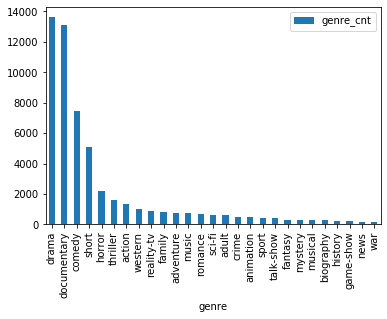

In [4]:
# Посмотрим распределение по жанрам

genre_count_df = train_df[['id','genre']].groupby('genre').agg('count').sort_values('id', ascending = False)

genre_count_df.reset_index(inplace = True)
genre_count_df.rename(columns ={'id':'genre_cnt'}, inplace = True)

genre_count_df.plot.bar(y = 'genre_cnt', x = 'genre')

genre_count_df

Опыты показали, что для нормального обучения сети нужно не меньше 7 000 примеров для каждого жанра, поэтому для улучшения результатов объединим близкие жанры

In [5]:
#['drama', 'biography', 'history', 'war']
#['documentary']
#['comedy', 'family', 'animation', 'musical']
#['short']
#['horror', 'thriller', 'sci-fi', 'fantasy', 'mystery']
#['action', 'western', 'adventure', 'crime']
#['reality-tv', 'news', 'sport', 'talk-show', 'game-show, music']
#['adult', 'romance']

groups = [['drama', 'biography', 'history', 'war'],
          ['documentary'],
          ['comedy', 'family', 'animation', 'musical']]

def join_genres_in_groups (p_genre, p_groups):
    '''Объеденение жанров в группы
    p_genre - название жанра
    p_groups - список груп
    '''
    
    res = 'other'
    
    for group in p_groups:
        if p_genre in group:
            res = ', '.join(group)
            break
        
        #if
    
    return res              

#join_genres_in_groups


In [6]:
train_df['genre'] = train_df['genre'].apply(lambda x: join_genres_in_groups(x, groups))

train_df

,id,title,genre,description
0,1,Oscar et la dame rose (2009),"drama, biography, history, war",Listening in to a conversation between his doc...
1,2,Cupid (1997),other,A brother and sister with a past incestuous re...
2,3,"Young, Wild and Wonderful (1980)",other,As the bus empties the students for their fiel...
3,4,The Secret Sin (1915),"drama, biography, history, war",To help their unemployed father make ends meet...
4,5,The Unrecovered (2007),"drama, biography, history, war",The film's title refers not only to the un-rec...
...,...,...,...,...
54209,54210,"""Bonino"" (1953)","comedy, family, animation, musical",This short-lived NBC live sitcom centered on B...
54210,54211,Dead Girls Don't Cry (????),other,The NEXT Generation of EXPLOITATION. The siste...
54211,54212,Ronald Goedemondt: Ze bestaan echt (2008),documentary,"Ze bestaan echt, is a stand-up comedy about gr..."
54212,54213,Make Your Own Bed (1944),"comedy, family, animation, musical",Walter and Vivian live in the country and have...


,genre,genre_cnt
0,other,17859
1,"drama, biography, history, war",14253
2,documentary,13096
3,"comedy, family, animation, musical",9006


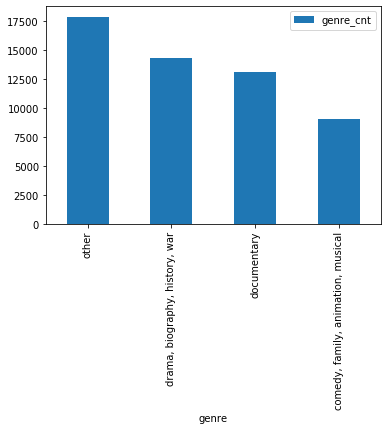

In [7]:
# Посмотрим распределение по жанрам после объединения

genre_count_df = train_df[['id','genre']].groupby('genre').agg('count').sort_values('id', ascending = False)

genre_count_df.reset_index(inplace = True)
genre_count_df.rename(columns ={'id':'genre_cnt'}, inplace = True)

genre_count_df.plot.bar(y = 'genre_cnt', x = 'genre')

genre_count_df

In [8]:
#Загружаем тестовые данные
test_df = load_movie_data ('data/test_data_solution.txt')

test_df

,id,title,genre,description
0,1,Edgar's Lunch (1998),thriller,"L.R. Brane loves his life - his car, his apart..."
1,2,La guerra de papá (1977),comedy,"Spain, March 1964: Quico is a very naughty chi..."
2,3,Off the Beaten Track (2010),documentary,One year in the life of Albin and his family o...
3,4,Meu Amigo Hindu (2015),drama,"His father has died, he hasn't spoken with his..."
4,5,Er nu zhai (1955),drama,Before he was known internationally as a marti...
...,...,...,...,...
54195,54196,"""Tales of Light & Dark"" (2013)",horror,"Covering multiple genres, Tales of Light & Dar..."
54196,54197,Der letzte Mohikaner (1965),western,As Alice and Cora Munro attempt to find their ...
54197,54198,Oliver Twink (2007),adult,"A movie 169 years in the making. Oliver Twist,..."
54198,54199,Slipstream (1973),drama,"Popular, but mysterious rock D.J Mike Mallard ..."


In [9]:
test_df['genre'] = test_df['genre'].apply(lambda x: join_genres_in_groups(x, groups))

test_df

,id,title,genre,description
0,1,Edgar's Lunch (1998),other,"L.R. Brane loves his life - his car, his apart..."
1,2,La guerra de papá (1977),"comedy, family, animation, musical","Spain, March 1964: Quico is a very naughty chi..."
2,3,Off the Beaten Track (2010),documentary,One year in the life of Albin and his family o...
3,4,Meu Amigo Hindu (2015),"drama, biography, history, war","His father has died, he hasn't spoken with his..."
4,5,Er nu zhai (1955),"drama, biography, history, war",Before he was known internationally as a marti...
...,...,...,...,...
54195,54196,"""Tales of Light & Dark"" (2013)",other,"Covering multiple genres, Tales of Light & Dar..."
54196,54197,Der letzte Mohikaner (1965),other,As Alice and Cora Munro attempt to find their ...
54197,54198,Oliver Twink (2007),other,"A movie 169 years in the making. Oliver Twist,..."
54198,54199,Slipstream (1973),"drama, biography, history, war","Popular, but mysterious rock D.J Mike Mallard ..."


## 2. Подготовка данных для модели


In [10]:
def tokenize_text (p_raw_text, p_stop_words):
    '''Функция для токенизации текста

    :param p_raw_text: исходная текстовая строка
    :param p_stop_words: список стоп слов
    '''
    
    tokenized_str = nltk.word_tokenize(p_raw_text)
    tokens = [i.lower() for i in tokenized_str if ( i not in string.punctuation )]
    filtered_tokens = [i for i in tokens if ( i not in p_stop_words )]
    
    return filtered_tokens

#tokenize_text

In [12]:
#разбиваем описание на токены

train_df['description_tokenized'] = train_df['description'].apply(lambda x:tokenize_text(x, stopwords.words('english')))
test_df['description_tokenized'] = test_df['description'].apply(lambda x:tokenize_text(x, stopwords.words('english')))

In [13]:
# создаем словарь

#словарь, составленный из описаний фильмов <word>:<id>
vocabulary = {}

max_val = 1000000

#добавляем зарезервированные слова
vocabulary["<PAD>"] = max_val + 2
vocabulary["<START>"] = max_val + 1
vocabulary["<UNKNOWN>"] = max_val

#посчитаем слова
for tokens in train_df.description_tokenized:
    for word in tokens:
        if word not in vocabulary.keys():
            vocabulary[word] = 1
        else:
            vocabulary[word] = vocabulary[word] + 1
            
#отсортируем слова по частоте
vocabulary = {k: v for k, v in sorted(vocabulary.items(), key=lambda item: item[1], reverse = True)}

#проиндексируем слова
cnt = 0
for k in vocabulary.keys():
    vocabulary[k] = cnt
    cnt = cnt + 1
#for
       
print('Количестов слов в словаре:',len(vocabulary))
print()
vocabulary

Количестов слов в словаре: 148141



{'<PAD>': 0,
 '<START>': 1,
 '<UNKNOWN>': 2,
 "'s": 3,
 "''": 4,
 '``': 5,
 'life': 6,
 'one': 7,
 'film': 8,
 'new': 9,
 'world': 10,
 'young': 11,
 'story': 12,
 'family': 13,
 'two': 14,
 'love': 15,
 'man': 16,
 'time': 17,
 'years': 18,
 'people': 19,
 'father': 20,
 "n't": 21,
 'find': 22,
 'first': 23,
 'get': 24,
 'lives': 25,
 'also': 26,
 'home': 27,
 'day': 28,
 'way': 29,
 'back': 30,
 'old': 31,
 'documentary': 32,
 'woman': 33,
 '...': 34,
 'mother': 35,
 'make': 36,
 'friends': 37,
 'girl': 38,
 'take': 39,
 'wife': 40,
 'takes': 41,
 'finds': 42,
 'work': 43,
 'son': 44,
 'three': 45,
 'city': 46,
 'show': 47,
 'help': 48,
 'like': 49,
 'town': 50,
 'school': 51,
 'many': 52,
 'friend': 53,
 'go': 54,
 'women': 55,
 'daughter': 56,
 'series': 57,
 'house': 58,
 'together': 59,
 'live': 60,
 'even': 61,
 'death': 62,
 'journey': 63,
 'around': 64,
 'war': 65,
 'gets': 66,
 'must': 67,
 'children': 68,
 'become': 69,
 'year': 70,
 'music': 71,
 'night': 72,
 'place': 73,


In [14]:
#создаем облегченный словарь
vocab_light = {}
for k, v in vocabulary.items():
    if v < 10000:
        vocab_light[k] = v

vocab_light

{'<PAD>': 0,
 '<START>': 1,
 '<UNKNOWN>': 2,
 "'s": 3,
 "''": 4,
 '``': 5,
 'life': 6,
 'one': 7,
 'film': 8,
 'new': 9,
 'world': 10,
 'young': 11,
 'story': 12,
 'family': 13,
 'two': 14,
 'love': 15,
 'man': 16,
 'time': 17,
 'years': 18,
 'people': 19,
 'father': 20,
 "n't": 21,
 'find': 22,
 'first': 23,
 'get': 24,
 'lives': 25,
 'also': 26,
 'home': 27,
 'day': 28,
 'way': 29,
 'back': 30,
 'old': 31,
 'documentary': 32,
 'woman': 33,
 '...': 34,
 'mother': 35,
 'make': 36,
 'friends': 37,
 'girl': 38,
 'take': 39,
 'wife': 40,
 'takes': 41,
 'finds': 42,
 'work': 43,
 'son': 44,
 'three': 45,
 'city': 46,
 'show': 47,
 'help': 48,
 'like': 49,
 'town': 50,
 'school': 51,
 'many': 52,
 'friend': 53,
 'go': 54,
 'women': 55,
 'daughter': 56,
 'series': 57,
 'house': 58,
 'together': 59,
 'live': 60,
 'even': 61,
 'death': 62,
 'journey': 63,
 'around': 64,
 'war': 65,
 'gets': 66,
 'must': 67,
 'children': 68,
 'become': 69,
 'year': 70,
 'music': 71,
 'night': 72,
 'place': 73,


In [15]:
#описываем функции кодирования/декодирования слов

def encode_tokens (p_tokens, p_vocabulary):
    '''Кодирования токенов (слов) в индексы словаря
    
    :param p_tokens: список токенов
    :param p_vocabulary: словарь <word>:<id>, c обязательными значениями {<PAD>:0, <START>:1, <UNKNOWN>: 2}
    '''
    res = []
     
    res = [p_vocabulary.get(word, p_vocabulary['<UNKNOWN>']) for word in p_tokens]
    
    return [p_vocabulary['<START>']] + res

#encode_tokens

def dencode_tokens (p_encoded_tokens, p_vocabulary):
    '''Декодирование токенов: индексы словаря -> в тоекны (слова)
    
    :p_encoded_tokens: список индексов словаря
    :param p_vocabulary: словарь <word>:<id>, c обязательными значениями {<PAD>:0, <START>:1, <UNKNOWN>: 2}
    '''
    
    res = []
    
    for index in p_encoded_tokens: 
        for word, v_index in p_vocabulary.items():
            if index == v_index:
                res.append(word)
                break
            #if
    
    return res
    
#dencode_tokens

#!!! проверка
#d_id = 11
#print(train_df.description_tokenized[d_id])
#print()
#encoded_tokens = encode_tokens (train_df.description_tokenized[d_id], vocabulary)
#print (encoded_tokens)
#print()
#print (dencode_tokens (encoded_tokens, vocabulary))


In [16]:
#кодируем описание фильмов

train_df['description_encoded'] = train_df['description_tokenized'].apply(lambda x: encode_tokens (x, vocab_light))

train_df

,id,title,genre,description,description_tokenized,description_encoded
0,1,Oscar et la dame rose (2009),"drama, biography, history, war",Listening in to a conversation between his doc...,"[listening, conversation, doctor, parents, 10-...","[1, 5073, 1846, 363, 132, 8656, 2786, 327, 205..."
1,2,Cupid (1997),other,A brother and sister with a past incestuous re...,"[brother, sister, past, incestuous, relationsh...","[1, 107, 151, 84, 2, 120, 781, 4109, 120, 1432..."
2,3,"Young, Wild and Wonderful (1980)",other,As the bus empties the students for their fiel...,"[bus, empties, students, field, trip, museum, ...","[1, 1574, 2, 271, 1110, 300, 1847, 827, 97, 10..."
3,4,The Secret Sin (1915),"drama, biography, history, war",To help their unemployed father make ends meet...,"[help, unemployed, father, make, ends, meet, e...","[1, 48, 2695, 20, 36, 437, 133, 6245, 1848, 15..."
4,5,The Unrecovered (2007),"drama, biography, history, war",The film's title refers not only to the un-rec...,"[film, 's, title, refers, un-recovered, bodies...","[1, 8, 3, 838, 5825, 2, 1370, 1222, 5022, 26, ..."
...,...,...,...,...,...,...
54209,54210,"""Bonino"" (1953)","comedy, family, animation, musical",This short-lived NBC live sitcom centered on B...,"[short-lived, nbc, live, sitcom, centered, bon...","[1, 7514, 6910, 60, 5521, 4883, 2, 8202, 1152,..."
54210,54211,Dead Girls Don't Cry (????),other,The NEXT Generation of EXPLOITATION. The siste...,"[next, generation, exploitation, sisters, kapa...","[1, 173, 755, 5632, 1021, 2, 2701, 6617, 58, 3..."
54211,54212,Ronald Goedemondt: Ze bestaan echt (2008),documentary,"Ze bestaan echt, is a stand-up comedy about gr...","[ze, bestaan, echt, stand-up, comedy, growing,...","[1, 2, 2, 2, 4298, 212, 631, 1062, 1072, 2, 66..."
54212,54213,Make Your Own Bed (1944),"comedy, family, animation, musical",Walter and Vivian live in the country and have...,"[walter, vivian, live, country, difficult, tim...","[1, 2316, 2, 60, 96, 704, 17, 1692, 6136, 2316..."


In [17]:
test_df['description_encoded'] = test_df['description_tokenized'].apply(lambda x: encode_tokens (x, vocab_light))

test_df

,id,title,genre,description,description_tokenized,description_encoded
0,1,Edgar's Lunch (1998),other,"L.R. Brane loves his life - his car, his apart...","[l.r, brane, loves, life, car, apartment, job,...","[1, 2, 2, 542, 6, 226, 547, 111, 761, 273, 2, ..."
1,2,La guerra de papá (1977),"comedy, family, animation, musical","Spain, March 1964: Quico is a very naughty chi...","[spain, march, 1964, quico, naughty, child, th...","[1, 1775, 1762, 6434, 2, 9283, 140, 45, 4304, ..."
2,3,Off the Beaten Track (2010),documentary,One year in the life of Albin and his family o...,"[one, year, life, albin, family, shepherds, no...","[1, 7, 70, 6, 2, 13, 2, 471, 2, 2489, 847, 678..."
3,4,Meu Amigo Hindu (2015),"drama, biography, history, war","His father has died, he hasn't spoken with his...","[father, died, n't, spoken, brother, 10, years...","[1, 20, 566, 21, 4155, 107, 824, 18, 1112, 112..."
4,5,Er nu zhai (1955),"drama, biography, history, war",Before he was known internationally as a marti...,"[known, internationally, martial, arts, supers...","[1, 189, 4389, 2123, 1063, 3530, 3062, 855, 32..."
...,...,...,...,...,...,...
54195,54196,"""Tales of Light & Dark"" (2013)",other,"Covering multiple genres, Tales of Light & Dar...","[covering, multiple, genres, tales, light, dar...","[1, 3790, 1842, 6370, 1612, 450, 235, 5978, 12..."
54196,54197,Der letzte Mohikaner (1965),other,As Alice and Cora Munro attempt to find their ...,"[alice, cora, munro, attempt, find, father, br...","[1, 1473, 8270, 2, 392, 22, 20, 571, 675, 674,..."
54197,54198,Oliver Twink (2007),other,"A movie 169 years in the making. Oliver Twist,...","[movie, 169, years, making, oliver, twist, art...","[1, 105, 2, 18, 186, 3037, 2054, 2, 2, 2, 1341..."
54198,54199,Slipstream (1973),"drama, biography, history, war","Popular, but mysterious rock D.J Mike Mallard ...","[popular, mysterious, rock, d.j, mike, mallard...","[1, 452, 228, 400, 2, 787, 2, 2, 8924, 47, 148..."


In [18]:
#Готовим данные для обучения
train_data = train_df.description_encoded.to_numpy()
train_labels = pd.get_dummies(train_df['genre']).values

test_data = test_df.description_encoded.to_numpy()
test_labels = pd.get_dummies(test_df['genre']).values


минимальная длина описания: 5
средняя длина описания: 60
максимальная длина описания: 1482


(array([6.50572586e-03, 2.41776121e-04, 1.82331166e-05, 3.37187773e-06,
        6.24421801e-07, 2.49768720e-07, 1.24884360e-07, 2.49768720e-07,
        0.00000000e+00, 1.24884360e-07]),
 array([   5. ,  152.7,  300.4,  448.1,  595.8,  743.5,  891.2, 1038.9,
        1186.6, 1334.3, 1482. ]),
 <a list of 10 Patch objects>)

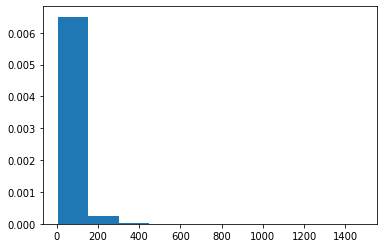

In [19]:
# Посчитаем среднюю длинну описания, чтобы определить длинну последовательности
train_df['description_len'] = train_df['description_encoded'].apply (len)

print ('минимальная длина описания:', train_df.description_len.min())
print ('средняя длина описания:', round(train_df.description_len.mean()))
print ('максимальная длина описания:', train_df.description_len.max())

plt.hist(train_df.description_len, density = True)

In [20]:
# Приведем все цепочки в датасете к одной длине с помощью паддинга

MAX_SEQ_LEN = 70

train_data = tf.keras.preprocessing.sequence.pad_sequences(
    train_data,
    value= vocabulary['<PAD>'],
    padding= 'post',
    maxlen= MAX_SEQ_LEN)

test_data = tf.keras.preprocessing.sequence.pad_sequences(
    test_data,
    value= vocabulary['<PAD>'],
    padding= 'post',
    maxlen= MAX_SEQ_LEN)

print('Тернировочные данные:')
print(train_data.shape)
print(train_data[0])
print()
print('Тестовые данные:')
print(test_data.shape)
print(test_data[0])

Тернировочные данные:
(54214, 70)
[   1 5073 1846  363  132 8656 2786  327 2057 1299  348 1113   60 4236
  804 1312  706 1719    2 1234  658 4980  109  444 8526  726 2642 1234
  742    2  472  614 8657 1765 4981 3514 1725 2786   60    6   15  315
  216   37 1247    2    2    2  357 2855 7293 1248    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0]

Тестовые данные:
(54200, 70)
[   1    2    2  542    6  226  547  111  761  273    2    7   28    2
    2  467    2    2  467  205  318 7041  982 1099 2388  300 1338  234
    2  844  112 3491  795 8322    2    3    6   77 3247  795    7  361
  561  103 4384    2  379 2643  165  580    2    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0]


In [21]:
#Разбьем обучающий датасет на обучающий и валидационный
partial_x_train, x_val, partial_y_train, y_val = train_test_split(train_data, train_labels, 
                                                                  test_size = 0.20, random_state = 42)

print(partial_x_train.shape, partial_y_train.shape)
print(x_val.shape, y_val.shape)

(43371, 70) (43371, 4)
(10843, 70) (10843, 4)


## 3. Создание и обучение модели

In [22]:
# Создадим рекурентную модель для классификации

VOCAB_SIZE = len(vocab_light)
# Размер векторного представления (эмбеддинга)
EMB_SIZE = 64
# Количество классов (жанров фильмов)
CLASS_NUM = y_val.shape[1]

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE, EMB_SIZE),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(EMB_SIZE, return_sequences=True, dropout=0.5, recurrent_dropout=0.5)),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(EMB_SIZE, return_sequences=False, dropout=0.5, recurrent_dropout=0.5)),
    tf.keras.layers.Dense(CLASS_NUM, activation= 'softmax'),
])

#model = tf.keras.Sequential([
#    tf.keras.layers.Embedding(VOCAB_SIZE, EMB_SIZE, input_length=train_data.shape[1]),
#    tf.keras.layers.SpatialDropout1D(0.2),
#    tf.keras.layers.LSTM(EMB_SIZE, dropout=0.2, recurrent_dropout=0.2),
#    tf.keras.layers.Dense(CLASS_NUM, activation= 'softmax'),
#])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          640000    
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         66048     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 4)                 516       
Total params: 805,380
Trainable params: 805,380
Non-trainable params: 0
_________________________________________________________________


In [23]:
#Обучение модели
BATCH_SIZE = 64
NUM_EPOCHS = 10

#Настраиваем объект для сохранения результатов работы модели
cpt_path = 'data/14_text_classifier.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_path, monitor='acc', verbose=1, save_best_only= True, mode='max')

model.compile(loss= 'categorical_crossentropy', optimizer='adam', metrics=['acc'])

#запускаем обучение
history= model.fit(partial_x_train, partial_y_train, validation_data= (x_val, y_val), 
                   epochs= NUM_EPOCHS, batch_size= BATCH_SIZE, verbose= 1,
                   callbacks=[checkpoint])


Epoch 1/10
678/678 [==============================] - ETA: 0s - loss: 1.0179 - acc: 0.5615
Epoch 00001: acc improved from -inf to 0.56153, saving model to data/14_text_classifier.hdf5
678/678 [==============================] - 102s 150ms/step - loss: 1.0179 - acc: 0.5615 - val_loss: 0.8727 - val_acc: 0.6493
Epoch 2/10
678/678 [==============================] - ETA: 0s - loss: 0.7878 - acc: 0.6865
Epoch 00002: acc improved from 0.56153 to 0.68654, saving model to data/14_text_classifier.hdf5
678/678 [==============================] - 101s 149ms/step - loss: 0.7878 - acc: 0.6865 - val_loss: 0.8666 - val_acc: 0.6441
Epoch 3/10
678/678 [==============================] - ETA: 0s - loss: 0.7106 - acc: 0.7249
Epoch 00003: acc improved from 0.68654 to 0.72489, saving model to data/14_text_classifier.hdf5
678/678 [==============================] - 102s 151ms/step - loss: 0.7106 - acc: 0.7249 - val_loss: 0.8976 - val_acc: 0.6327
Epoch 4/10
678/678 [==============================] - ETA: 0s - los

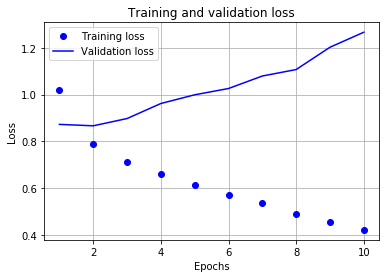

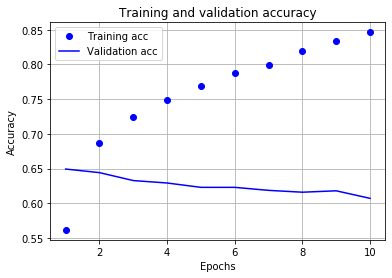

In [24]:
#отобразим графики обучения

epochs = range(1, len(history.history['acc']) + 1)

plt.figure()
plt.plot(epochs, history.history['loss'], 'bo', label='Training loss')
plt.plot(epochs, history.history['val_loss'], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.figure()
plt.plot(epochs, history.history['acc'], 'bo', label='Training acc')
plt.plot(epochs, history.history['val_acc'], 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

In [25]:
# оценим качество на тестовом датасете

results = model.evaluate(test_data, test_labels)

print('Test loss: {:.4f}'.format(results[0]))
print('Test accuracy: {:.2f} %'.format(results[1]*100))

1694/1694 [==============================] - 27s 16ms/step - loss: 1.2905 - acc: 0.6018
Test loss: 1.2905
Test accuracy: 60.18 %
